In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


In [27]:
# 1. Define the quadratic function without haiku
def quadratic_fn(x):
    return x ** 2 - 2 * x + 1

# 2. Compute its gradient using jax
grad_fn = jax.jit(jax.grad(quadratic_fn))

# 3. Set up a gradient descent optimizer using optax
lr = 0.1
optimizer = optax.sgd(lr)

# 4. Create a loop to perform gradient descent
num_steps = 50
params = {'x': jnp.array(10.0)}  # starting point
opt_state = optimizer.init(params)
history = [params['x']]

for _ in range(num_steps):
    grads = {'x': grad_fn(params['x'])}  # Compute gradient for the current value of x
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    history.append(params['x'])




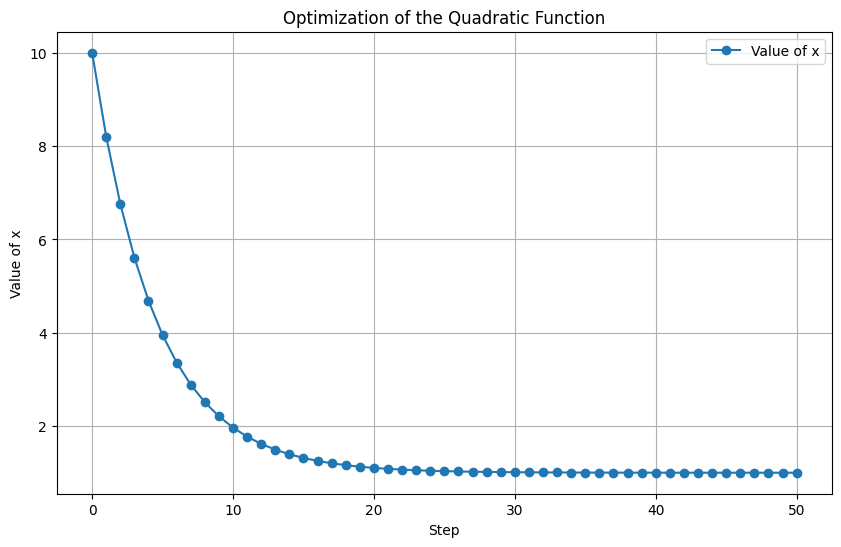

In [28]:
import matplotlib.pyplot as plt

# Plotting the values
plt.figure(figsize=(10, 6))
plt.plot(history, '-o', label='Value of x')
plt.xlabel('Step')
plt.ylabel('Value of x')
plt.title('Optimization of the Quadratic Function')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Define the Lagrangian
def lagrangian(x, lam):
    f = x ** 2 - 2 * x + 1
    g = x - 2
    return f + lam * jnp.maximum(0, g)

# Compute its gradient using jax with respect to x
grad_lagrangian = jax.jit(jax.grad(lagrangian, argnums=0))

# Initial lambda value and increase factor
lam = 0.1
lam_increase_factor = 1.01

# Updated loop to perform gradient descent with the Lagrangian
params = {'x': jnp.array(5.0)}  # starting point
opt_state = optimizer.init(params)
lagrangian_history = [lagrangian(params['x'], lam)]
x_history = [params['x']]

for _ in range(num_steps):
    grads = {'x': grad_lagrangian(params['x'], lam)}
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Increase lambda to enforce the constraint more strongly
    lam *= lam_increase_factor
    
    x_history.append(params['x'])
    lagrangian_history.append(lagrangian(params['x'], lam))

x_history[:10], lagrangian_history[:10]  # Display the first 10 steps


([Array(5., dtype=float32, weak_type=True),
  Array(4.19, dtype=float32),
  Array(3.5419002, dtype=float32),
  Array(3.0233192, dtype=float32),
  Array(2.6083524, dtype=float32),
  Array(2.2762759, dtype=float32),
  Array(2.0105107, dtype=float32),
  Array(1.7977934, dtype=float32),
  Array(1.6382347, dtype=float32),
  Array(1.5105878, dtype=float32)],
 [Array(16.3, dtype=float32, weak_type=True),
  Array(10.397291, dtype=float32),
  Array(6.618545, dtype=float32),
  Array(4.199253, dtype=float32),
  Array(2.650103, dtype=float32),
  Array(1.6579169, dtype=float32),
  Array(1.0222477, dtype=float32),
  Array(0.6364744, dtype=float32),
  Array(0.40734363, dtype=float32),
  Array(0.2607, dtype=float32)])

In [71]:
import jax
import jax.numpy as jnp
import optax

# Define the Lagrangian
def lagrangian(x, lam):
    f = x ** 2 - 2 * x + 1
    g = x - 2
    return f + lam * g

# Gradient of the Lagrangian with respect to x and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=1))

# Modify the gradient functions to always return gradients for both 'x' and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['lambda'])
    grad_lambda = grad_lagrangian_lambda(params['x'], params['lambda'])
    return {'x': grad_x, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Optimization setup
optimizer = optax.sgd(0.05)

# Starting values for x and lambda
params = {'x': jnp.array(5.0), 'lambda': jnp.array(0.0)}
opt_state = optimizer.init(params)

# Lists to store history of x, lambda, and Lagrangian values
x_kkt_history = [params['x']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['lambda'])]

# KKT conditions loop with combined gradient updates
constraint_hit = 0
for n in range(num_steps):
    # Update both x and lambda using combined gradients
    grads = grad_fn_combined(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce dual feasibility (lambda >= 0)
    params['lambda'] = jnp.maximum(0, params['lambda'])
    
    if params['lambda'] > 0 and constraint_hit == 0:
        constraint_hit = n
    # Store values in history
    x_kkt_history.append(params['x'])
    lambda_kkt_history.append(params['lambda'])
    lagrangian_kkt_history.append(lagrangian(params['x'], params['lambda']))


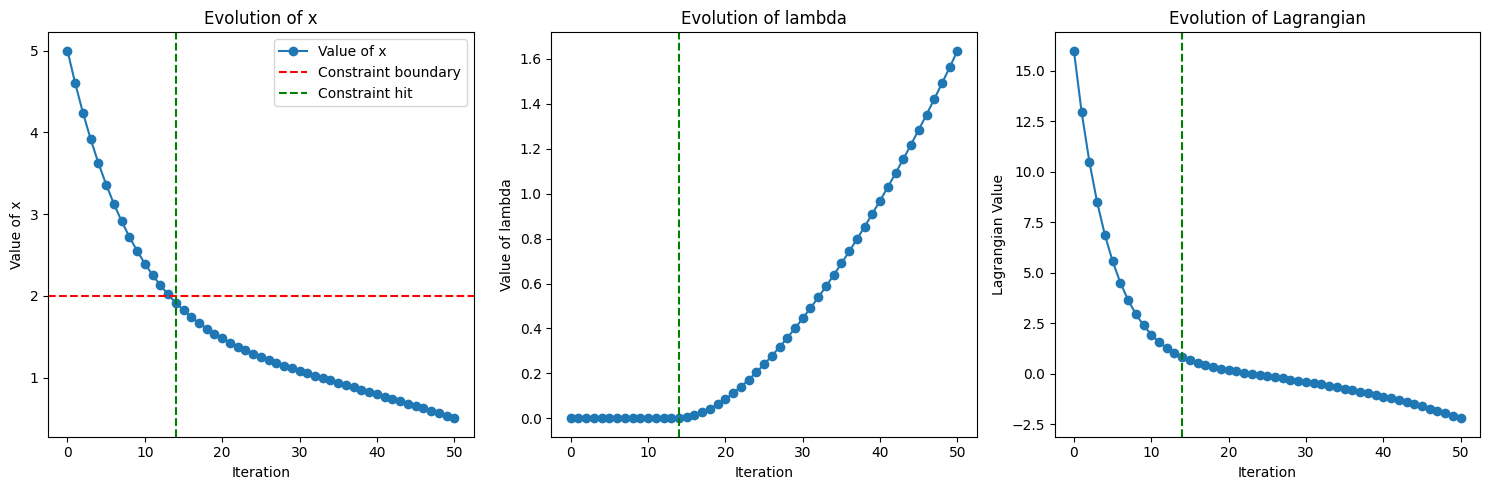

In [72]:
import matplotlib.pyplot as plt

# Plot value of x over iterations
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_kkt_history, '-o', label='Value of x')
plt.axhline(y=2, color='r', linestyle='--', label='Constraint boundary')
plt.axvline(x=constraint_hit, color='g', linestyle='--', label='Constraint hit')
plt.xlabel('Iteration')
plt.ylabel('Value of x')
plt.legend()
plt.title('Evolution of x')

# Plot value of lambda over iterations
plt.subplot(1, 3, 2)
plt.plot(lambda_kkt_history, '-o', label='Value of lambda')
plt.axvline(x=constraint_hit, color='g', linestyle='--', label='Constraint hit')
plt.xlabel('Iteration')
plt.ylabel('Value of lambda')
plt.title('Evolution of lambda')

# Plot Lagrangian value over iterations
plt.subplot(1, 3, 3)
plt.plot(lagrangian_kkt_history, '-o', label='Lagrangian value')
plt.axvline(x=constraint_hit, color='g', linestyle='--', label='Constraint hit')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian Value')
plt.title('Evolution of Lagrangian')

plt.tight_layout()
plt.show()
